# deep learning personal project : 🍔👁 Food Vision Big™ PART 2

source dataset : https://www.kaggle.com/datasets/dansbecker/food-101

model : EfficientNetB1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn
import tensorflow as tf

In [ ]:
# GPU Choose for runtime

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-00846cc3-6990-311b-3110-3bda376cd5d4)


In [ ]:
# Added help function
# Import script function on Github

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-15 09:22:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-15 09:22:59 (50.6 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [ ]:
# Get tensorflow dataset

import tensorflow_datasets as tfds

In [ ]:
# Get tensorflow dataset TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [ ]:
# Load in the data and target dataset to get from TFDS
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [ ]:
image[:2]

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]]], dtype=uint8)>

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

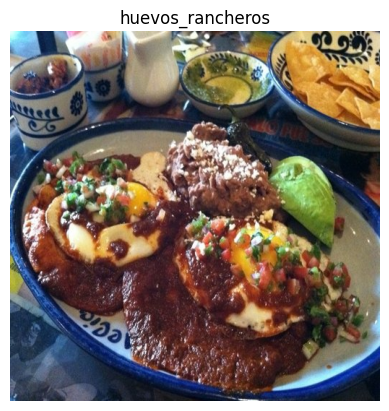

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing the data

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_size=224):
  """
    Converts image datatype from 'uint8' -> 'float16' and reshapes image to
    [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)  # return (float16_image, label) tuple
  return image, label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.6  253.6  251.  ]
  [223.   255.   252.2 ]
  [207.1  255.   250.4 ]
  ...
  [140.6  129.5  121.25]
  [121.1  115.25 116.94]
  [ 83.94  83.06  89.6 ]]

 [[221.5  254.4  253.4 ]
  [214.5  255.   253.9 ]
  [198.4  254.6  252.  ]
  ...
  [208.6  195.9  173.4 ]
  [197.   190.1  174.9 ]
  [175.5  171.6  161.2 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float16'>


In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Create Model

EfficientNetB1

In [ ]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

In [ ]:
# EarlyStopping Callback

early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

In [ ]:
# ReduceLROnPlateau Callback

lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)

In [ ]:
# Turn on mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0     

In [ ]:
history_model_EfficientNetB1= model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                               early_stopping_callback,
                               lower_lr])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20240115-092309
Epoch 1/50
2368/2368 [==============================] - 635s 236ms/step - loss: 1.7499 - accuracy: 0.5573 - val_loss: 1.1031 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 2/50
2368/2368 [==============================] - 545s 229ms/step - loss: 1.1459 - accuracy: 0.6963 - val_loss: 1.0699 - val_accuracy: 0.7142 - lr: 0.0010
Epoch 3/50
2368/2368 [==============================] - 545s 229ms/step - loss: 0.9271 - accuracy: 0.7472 - val_loss: 0.9473 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/50
2368/2368 [==============================] - 541s 228ms/step - loss: 0.7764 - accuracy: 0.7833 - val_loss: 0.9303 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 5/50
2368/2368 [==============================] - 540s 227ms/step - loss: 0.6545 - accuracy: 0.8130 - val_loss: 0.9628 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 6/50
2368/2368 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8360
Epoch 6: ReduceLRO

In [ ]:
# save model
save_dir = "/content/drive/MyDrive/Food_vision/efficientnetb1_model_mixed_precision_for_food_vision"
model.save(save_dir)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 64s 80ms/step - loss: 0.7275 - accuracy: 0.8407


[0.7274845242500305, 0.84071284532547]

# Evaluate Model

In [ ]:
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 [==============================] - 59s 71ms/step


(25250, (25250, 101))

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [ ]:
# Getting true labels for the test_data

y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# Predicted Labels vs. True Labels
pred_classes==y_labels

array([ True,  True,  True, ..., False,  True,  True])

Sklearn's Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.8407128712871287

Confusion Matrix

In [ ]:
import seaborn as sns

cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sns.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model's Class-wise Accuracy Score

In [ ]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6443514644351465,
 'baby_back_ribs': 0.8176352705410821,
 'baklava': 0.878727634194831,
 'beef_carpaccio': 0.8875739644970414,
 'beef_tartare': 0.8156862745098038,
 'beet_salad': 0.7520661157024793,
 'beignets': 0.85546875,
 'bibimbap': 0.9261477045908183,
 'bread_pudding': 0.6628131021194604,
 'breakfast_burrito': 0.7887323943661971,
 'bruschetta': 0.766734279918864,
 'caesar_salad': 0.8631178707224334,
 'cannoli': 0.8929292929292929,
 'caprese_salad': 0.8392156862745097,
 'carrot_cake': 0.8286852589641432,
 'ceviche': 0.7306889352818372,
 'cheesecake': 0.7434343434343434,
 'cheese_plate': 0.8902439024390244,
 'chicken_curry': 0.7854251012145749,
 'chicken_quesadilla': 0.8336673346693386,
 'chicken_wings': 0.8548707753479126,
 'chocolate_cake': 0.7429718875502008,
 'chocolate_mousse': 0.6431372549019607,
 'churros': 0.8971193415637859,
 'clam_chowder': 0.8987854251012145,
 'club_sandwich': 0.8814229249011858,
 'crab_cakes': 0.7677165354330708,
 'creme_brulee': 0.927308